# Segmentation of Indian Traffic

In [1]:
import math
from PIL import Image, ImageDraw
#https://www.geeksforgeeks.org/python-pillow-a-fork-of-pil/

from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [2]:
import pathlib
img_object=pathlib.Path('data/images')
image_files=list(img_object.glob('*/*'))
image_files

[PosixPath('data/images/216/frame0825_leftImg8bit.jpg'),
 PosixPath('data/images/216/frame1485_leftImg8bit.jpg'),
 PosixPath('data/images/216/frame0419_leftImg8bit.jpg'),
 PosixPath('data/images/216/frame0285_leftImg8bit.jpg'),
 PosixPath('data/images/216/frame0509_leftImg8bit.jpg'),
 PosixPath('data/images/216/frame1155_leftImg8bit.jpg'),
 PosixPath('data/images/216/frame1245_leftImg8bit.jpg'),
 PosixPath('data/images/216/frame0091_leftImg8bit.jpg'),
 PosixPath('data/images/216/frame1305_leftImg8bit.jpg'),
 PosixPath('data/images/216/frame0885_leftImg8bit.jpg'),
 PosixPath('data/images/267/frame4623_leftImg8bit.jpg'),
 PosixPath('data/images/267/frame4443_leftImg8bit.jpg'),
 PosixPath('data/images/267/frame2613_leftImg8bit.jpg'),
 PosixPath('data/images/267/frame2823_leftImg8bit.jpg'),
 PosixPath('data/images/267/frame0393_leftImg8bit.jpg'),
 PosixPath('data/images/267/frame1413_leftImg8bit.jpg'),
 PosixPath('data/images/267/frame0933_leftImg8bit.jpg'),
 PosixPath('data/images/267/fra

In [3]:
mask_dir=pathlib.Path('data/mask')
mask_files=list(mask_dir.glob('*/*'))
mask_files

[PosixPath('data/mask/216/frame1155_gtFine_polygons.json'),
 PosixPath('data/mask/216/frame0285_gtFine_polygons.json'),
 PosixPath('data/mask/216/frame0885_gtFine_polygons.json'),
 PosixPath('data/mask/216/frame0509_gtFine_polygons.json'),
 PosixPath('data/mask/216/frame0091_gtFine_polygons.json'),
 PosixPath('data/mask/216/frame0419_gtFine_polygons.json'),
 PosixPath('data/mask/216/frame1485_gtFine_polygons.json'),
 PosixPath('data/mask/216/frame1305_gtFine_polygons.json'),
 PosixPath('data/mask/216/frame1245_gtFine_polygons.json'),
 PosixPath('data/mask/216/frame0825_gtFine_polygons.json'),
 PosixPath('data/mask/267/frame0633_gtFine_polygons.json'),
 PosixPath('data/mask/267/frame4323_gtFine_polygons.json'),
 PosixPath('data/mask/267/frame4203_gtFine_polygons.json'),
 PosixPath('data/mask/267/frame0813_gtFine_polygons.json'),
 PosixPath('data/mask/267/frame3813_gtFine_polygons.json'),
 PosixPath('data/mask/267/frame0933_gtFine_polygons.json'),
 PosixPath('data/mask/267/frame1413_gtFi

In [4]:
print(len(mask_files))
print(len(image_files))

4008
4008


In [5]:
json_files=[]
for img in image_files:
    dir_list=str(img).split('/')
    img_name=str(img).split('/')[-1]
    
    #print(str(img).split('/')[-1])
    
    frame_name=img_name.split('_')[0]
    json_dir=dir_list[0]+'/mask/'+dir_list[2]+'/'+ frame_name + '_gtFine_polygons.json'
    json_files.append(json_dir)

In [6]:
data_df=pd.DataFrame([image_files,json_files]).transpose()

In [7]:
data_df.head(5)

0  \
0  data/images/216/frame0825_leftImg8bit.jpg   
1  data/images/216/frame1485_leftImg8bit.jpg   
2  data/images/216/frame0419_leftImg8bit.jpg   
3  data/images/216/frame0285_leftImg8bit.jpg   
4  data/images/216/frame0509_leftImg8bit.jpg   

                                              1  
0  data/mask/216/frame0825_gtFine_polygons.json  
1  data/mask/216/frame1485_gtFine_polygons.json  
2  data/mask/216/frame0419_gtFine_polygons.json  
3  data/mask/216/frame0285_gtFine_polygons.json  
4  data/mask/216/frame0509_gtFine_polygons.json

In [8]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    img_object=pathlib.Path('data/images')
    image_files=list(img_object.glob('*/*'))
    image_files=[str(i) for i in image_files]
    json_files=[]
    
    for img in image_files:
        dir_list=str(img).split('/')
        img_name=str(img).split('/')[-1]
        #print(str(img).split('/')[-1])
        frame_name=img_name.split('_')[0]
        json_dir=dir_list[0]+'/mask/'+dir_list[2]+'/'+ frame_name + '_gtFine_polygons.json'
        json_files.append(json_dir)
    data_df=pd.DataFrame([image_files,json_files]).transpose()
    data_df.columns=['images','json']
    return data_df

In [9]:
root_dir='data/images'
data_df = return_file_names_df(root_dir)
data_df.head()

images  \
0  data/images/216/frame0825_leftImg8bit.jpg   
1  data/images/216/frame1485_leftImg8bit.jpg   
2  data/images/216/frame0419_leftImg8bit.jpg   
3  data/images/216/frame0285_leftImg8bit.jpg   
4  data/images/216/frame0509_leftImg8bit.jpg   

                                           json  
0  data/mask/216/frame0825_gtFine_polygons.json  
1  data/mask/216/frame1485_gtFine_polygons.json  
2  data/mask/216/frame0419_gtFine_polygons.json  
3  data/mask/216/frame0285_gtFine_polygons.json  
4  data/mask/216/frame0509_gtFine_polygons.json

> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [10]:
def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [11]:
grader_1(data_df)

True

In [12]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [13]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and return them
    # if open any json file using any editor you will get better sense of it
    unique_class=set()
    for files in tqdm(data_df['json']):
        f=open(files)
        data=json.load(f)
        for obj in data['objects']:
            unique_class.add(obj['label'])
    unique_labels=list(unique_class)
    return unique_labels

In [14]:
unique_labels = return_unique_labels(data_df)

100%|██████████████████████████████████████████████████████████████████████| 4008/4008 [00:53<00:00, 75.11it/s]


<img src='https://i.imgur.com/L4QH6Tp.png'>

In [15]:
len(unique_labels)

40

In [16]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [17]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [18]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    f=open(file)
    data=json.load(f)
    h=data['imgHeight']
    w=data['imgWidth']
    label=list()
    vertexlist=list()
    for obj in data['objects']:
        label.append(obj['label']) 
        vertexlist.append([tuple(i) for i in obj['polygon']])
    
    #print(w,h,len(set(label)), len(vertexlist))
    #print(isinstance(vertexlist,list), isinstance(vertexlist[0],list), isinstance(vertexlist[0][0],tuple))
    return w, h, label, vertexlist

In [19]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 

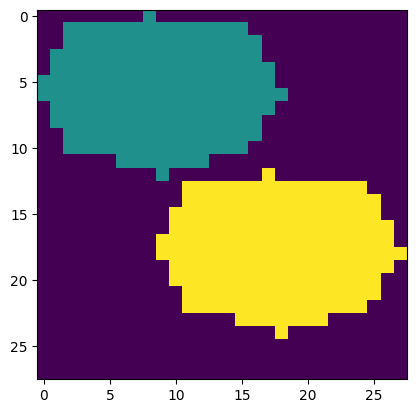

In [20]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =10)
# writing the second polygon
img1.polygon(x2, fill =20)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:2])
im.save("test_image.png")

In [21]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    output_files=[]
    for json_files in tqdm(data_df['json']):
        f=json_files.split('.')[0]
        file_name=f.split('/')
        w, h, label, vertexlist=get_poly(json_files)
        img = Image.new("RGB", (w, h))
        img1 = ImageDraw.Draw(img)
        for i in range(len(vertexlist)):
            if len(vertexlist[i])>=2:
                img1.polygon(vertexlist[i], fill = label_clr[label[i]])
        if os.path.exists(file_name[0]+'/output/'+file_name[2]):
            img=np.array(img)
            im=Image.fromarray(img[:,:,0])
            im.save(file_name[0]+'/output/'+file_name[2]+'/'+file_name[-1]+'.jpg')
            del img
        else:
            os.makedirs(file_name[0]+'/output/'+file_name[2])
            img=np.array(img)
            im=Image.fromarray(img[:,:,0])
            im.save(file_name[0]+'/output/'+file_name[2]+'/'+file_name[-1]+'.jpg')
            del img
        output_files.append(file_name[0]+'/output/'+file_name[2]+'/'+file_name[-1]+'.jpg')
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    data_df['mask']=output_files
    
    
    
    return data_df

In [62]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████████████████████████████████████████████████████████████████| 4008/4008 [04:41<00:00, 14.24it/s]


images  \
0  data/images/216/frame0825_leftImg8bit.jpg   
1  data/images/216/frame1485_leftImg8bit.jpg   
2  data/images/216/frame0419_leftImg8bit.jpg   
3  data/images/216/frame0285_leftImg8bit.jpg   
4  data/images/216/frame0509_leftImg8bit.jpg   

                                           json  \
0  data/mask/216/frame0825_gtFine_polygons.json   
1  data/mask/216/frame1485_gtFine_polygons.json   
2  data/mask/216/frame0419_gtFine_polygons.json   
3  data/mask/216/frame0285_gtFine_polygons.json   
4  data/mask/216/frame0509_gtFine_polygons.json   

                                            mask  
0  data/output/216/frame0825_gtFine_polygons.jpg  
1  data/output/216/frame1485_gtFine_polygons.jpg  
2  data/output/216/frame0419_gtFine_polygons.jpg  
3  data/output/216/frame0285_gtFine_polygons.jpg  
4  data/output/216/frame0509_gtFine_polygons.jpg

In [ ]:
'''data/mask/347/frame9131_gtFine_polygons.json
data/mask/347/frame8801_gtFine_polygons.json
data/mask/383/frame16044_gtFine_polygons.json
data/mask/306/frame5209_gtFine_polygons.json
data/mask/354/frame0011_gtFine_polygons.json
data/mask/320/frame9579_gtFine_polygons.json
data/mask/302/frame9727_gtFine_polygons.json
'''
#The following files have some vertex as [] that is empty list

In [ ]:
print(len(vertexlist))

212


In [63]:
'''#daving the final dataframe to a csv file
data_df.to_csv('preprocessed_data.csv', index=False)'''

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

In [2]:
import pandas as pd
data=pd.read_csv('preprocessed_data.csv', delimiter=',')

In [3]:
from sklearn.model_selection import train_test_split
train_1, test=train_test_split(data, test_size=0.2)
train, validation=train_test_split(train_1, test_size=0.2)

In [4]:
%env SM_FRAMEWORK=tf.keras
import tensorflow as tf
from tensorflow.keras.utils import get_source_inputs

import segmentation_models as sm

import segmentation_models as sm
from segmentation_models import Unet

tf.keras.backend.set_image_data_format('channels_last')

env: SM_FRAMEWORK=tf.keras


2023-02-17 13:01:10.928830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 13:01:14.382898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-02-17 13:01:14.384106: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such fil

Segmentation Models: using `tf.keras` framework.


In [5]:
model_1 = Unet('resnet50', encoder_weights='imagenet', classes=21, activation='softmax', input_shape=(512,512,3))

2023-02-17 13:01:19.941627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 13:01:20.125827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 13:01:20.126987: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 13:01:20.131201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [6]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [7]:
labels=sorted(list(set(label_clr.values())))

In [8]:
# import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
import imgaug.augmenters as iaa

aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [9]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    
def normalize_image(mask):
    mask = mask/255
    return mask

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = label_clr.values()
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self,image_dir, mask_image_dir, classes):
        
        
        self.images_fps   = image_dir
        # the paths of segmentation images
        self.masks_fps    = mask_image_dir
        # giving labels for each class
        self.class_values = classes
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image=cv2.resize(image, (512,512),interpolation=cv2.INTER_AREA)
        image=image/255
        
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask=cv2.resize(mask, (512,512),interpolation=cv2.INTER_AREA)
        
        image_masks = [(mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float32')
   
        a = np.random.uniform()
        if a<0.2:
            image = image
            image_mask = image_mask
        elif a<0.4:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.6:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        elif a<0.8:
            image = aug5.augment_image(image)
            image_mask = image_mask
        else:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
    def __len__(self):
        return (len(self.images_fps))
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [10]:
# Dataset for train images
CLASSES = labels
train_mask_image_dir=train['mask'].values
train_image_dir=train['images'].values

test_mask_image_dir=test['mask'].values
test_image_dir=test['images'].values

validation_mask_image_dir=validation['mask'].values
validation_image_dir=validation['images'].values

train_dataset = Dataset(train_image_dir,train_mask_image_dir, classes=CLASSES)
test_dataset  = Dataset(test_image_dir,test_mask_image_dir, classes=CLASSES)
validation_dataset  = Dataset(validation_image_dir,validation_mask_image_dir, classes=CLASSES)

BATCH_SIZE=10

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = Dataloder(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)


print(train_dataloader[0][0].shape)
print(test_dataloader[0][0].shape)
print(validation_dataloader[0][0].shape)

assert train_dataloader[0][0].shape == (BATCH_SIZE,512,512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE,512,512, 21)

(10, 512, 512, 3)
(10, 512, 512, 3)
(10, 512, 512, 3)


In [11]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet

optim = tf.keras.optimizers.experimental.Nadam(learning_rate=0.001)

focal_loss = sm.losses.cce_dice_loss


# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model_1.compile(optim, focal_loss, metrics=[iou_score])

In [36]:
from tensorflow.keras.callbacks import Callback

class custom_callback(Callback):
    def __init__(self):
        super().__init__()
        pass
    def on_epoch_end(self,epoch, logs=None):
        self.model.save_weights('model/model_1_ep_'+str(epoch)+'.h5')
        pass
    

In [38]:
path='model/model_1.h5'
logs='logs/model_1'
tensorboard=tf.keras.callbacks.TensorBoard(log_dir=logs,)
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=path, monitor= 'val_iou_score',
    save_best_only = True,
    mode='auto',save_weights_only=True)
save_model=custom_callback()
callbacks=[checkpoint,tensorboard,save_model]

model_1.fit(train_dataloader, epochs=15, validation_data=validation_dataloader, callbacks=callbacks)

Epoch 1/15
256/256 [==============================] - 436s 2s/step - loss: 0.8066 - iou_score: 0.1886 - val_loss: 1.2651 - val_iou_score: 0.0157
Epoch 2/15
256/256 [==============================] - 436s 2s/step - loss: 0.7023 - iou_score: 0.2663 - val_loss: 1.1088 - val_iou_score: 0.0577
Epoch 3/15
256/256 [==============================] - 432s 2s/step - loss: 0.6474 - iou_score: 0.3074 - val_loss: 1.0052 - val_iou_score: 0.1027
Epoch 4/15
256/256 [==============================] - 436s 2s/step - loss: 0.6163 - iou_score: 0.3332 - val_loss: 0.8152 - val_iou_score: 0.2056
Epoch 5/15
256/256 [==============================] - 442s 2s/step - loss: 0.5978 - iou_score: 0.3491 - val_loss: 0.6264 - val_iou_score: 0.3293
Epoch 6/15
256/256 [==============================] - 436s 2s/step - loss: 0.5791 - iou_score: 0.3666 - val_loss: 0.7492 - val_iou_score: 0.2573
Epoch 7/15
256/256 [==============================] - 420s 2s/step - loss: 0.5690 - iou_score: 0.3748 - val_loss: 0.7353 - val_iou

In [39]:
model_1.optimizer.lr = 0.0005

In [40]:
model_1.fit(train_dataloader, epochs=15, validation_data=validation_dataloader, callbacks=callbacks)

Epoch 1/15
256/256 [==============================] - 416s 2s/step - loss: 0.4714 - iou_score: 0.4790 - val_loss: 0.6070 - val_iou_score: 0.1517
Epoch 2/15
256/256 [==============================] - 412s 2s/step - loss: 0.4599 - iou_score: 0.4894 - val_loss: 0.5067 - val_iou_score: 0.4424
Epoch 3/15
256/256 [==============================] - 405s 2s/step - loss: 0.4581 - iou_score: 0.4902 - val_loss: 0.5447 - val_iou_score: 0.4041
Epoch 4/15
256/256 [==============================] - 411s 2s/step - loss: 0.4515 - iou_score: 0.4983 - val_loss: 0.5470 - val_iou_score: 0.4007
Epoch 5/15
256/256 [==============================] - 408s 2s/step - loss: 0.4456 - iou_score: 0.5022 - val_loss: 0.5124 - val_iou_score: 0.4540
Epoch 6/15
256/256 [==============================] - 408s 2s/step - loss: 0.4422 - iou_score: 0.5008 - val_loss: 0.4904 - val_iou_score: 0.4645
Epoch 7/15
256/256 [==============================] - 408s 2s/step - loss: 0.4393 - iou_score: 0.5072 - val_loss: 0.5216 - val_iou

In [12]:
model_1.load_weights('model/model_1_ep_14.h5')

In [41]:
model_1.evaluate(test_dataloader)

80/80 [==============================] - 100s 1s/step - loss: 0.3197 - iou_score: 0.6406


[0.3196704685688019, 0.6405974626541138]

#### Visualizing the Outputs:

In [16]:
test_dataloader[0][0].shape
test_dataloader[0][1].shape
predicted_masks=model_1.predict(test_dataloader[0][0])

1/1 [==============================] - 0s 53ms/step


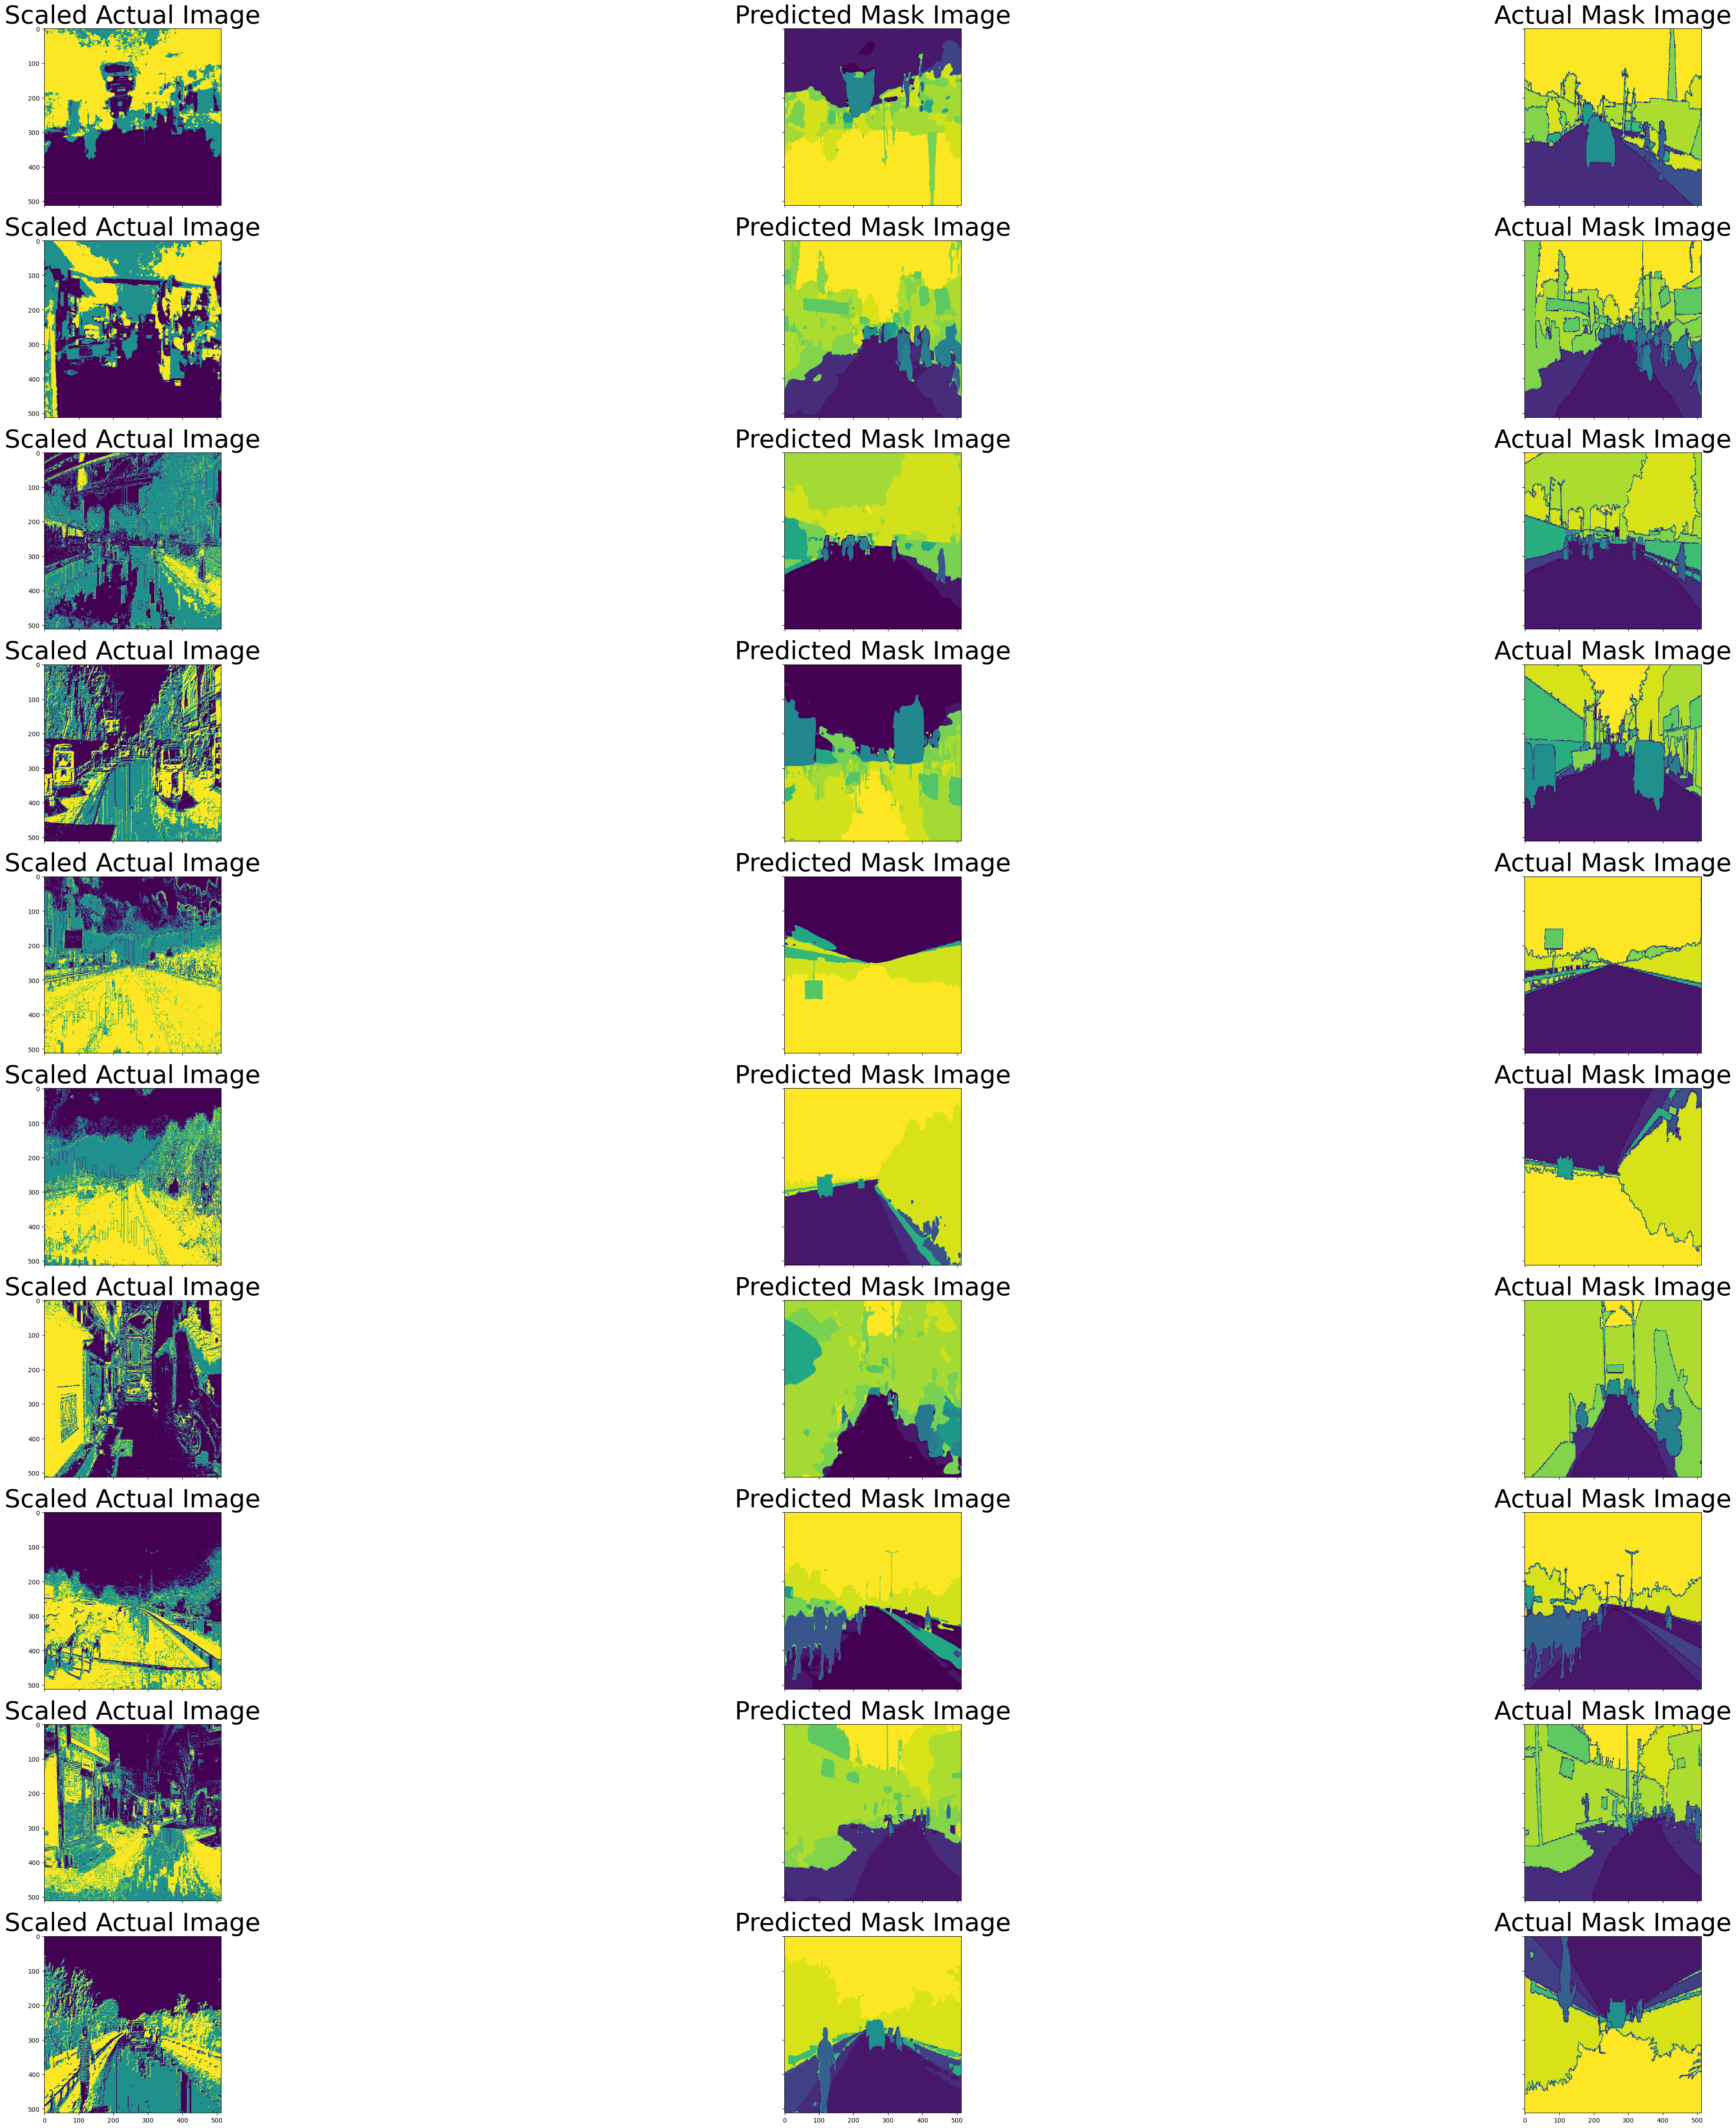

In [18]:
fig,ax=plt.subplots(10,3,figsize=(60, 60), squeeze=False,sharex=True, sharey=True)

for i in range(10):
    ax[i,0].imshow(np.argmax(test_dataloader[0][0][i], axis=-1))
    ax[i,0].set_title('Scaled Actual Image',fontsize = 40)
    ax[i,1].imshow(np.argmax(predicted_masks[i], axis=-1))
    ax[i,1].set_title('Predicted Mask Image',fontsize = 40)
    ax[i,2].imshow(np.argmax(test_dataloader[0][1][i], axis=-1))
    ax[i,2].set_title('Actual Mask Image',fontsize = 40)

In [75]:
test_dataloader[0][1][0].shape

(512, 512, 21)

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

In [ ]:
## Answers

#### Why is Dice Loss, better than Cross Entropy Loss and what is its need?
- Cross Entropy, would mean to change the whole segmentation or object detection problem as a classification problem. But there are a few reasons because of which they fail:
1) Cross Entropy, considers the average loss per pixel, which means it is not focused towards each pixel but is more focused globally, hence not helping the model learn in the best manner which is needed for image related problems.
2) Cross Entropy, gives us the probability scores at a pixel level, but it does not show how much far the neighboring "1" pixel is present, making it less effective in training the model.
3) Finally, in our images consider we have a histogram of the pixels on the images, that is we try to understand the pixel distribution of each class on the image. Then we can notice that the distribution of pixel is uneven accross the images,hence making it tough for the model to learn. We can however introduce weights in each class, but that would not help much.

Reference: https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b

#### The Formula for Dice Loss is as follows:
![image.png](attachment:image.png)

- Here g_i and p_i are "ground_truth_values" and "predicted_values", so it is the product of both the values for the coresponding pixel. Divided by the sum of both the values.
- The Dice Loss, varies from 0-1, and the best value when both of them coincide is "1", and the worst case scenario is 0.
- Because when both the values will completely match, the value will become 1.

![image.png](attachment:image.png)

### The above picture illustrates the formula in a better manner.

# ************************************************

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

# Task 3: Training CANet

In [27]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [26]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, ReLU, Add ,Activation

In [28]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="conv_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        
    def build(self, input_shape):
        self.layer_1=Conv2D(self.F1,kernel_size=(1,1), strides=(1,1),padding='same')
        self.activation_layer_1=Activation('relu')
        self.activation_layer_2=Activation('relu')
        self.activation_layer_3=Activation('relu')
        self.activation_layer_4=Activation('relu')
        self.activation_layer_5=Activation('relu')
        
        self.layer_2=Conv2D(self.F2,kernel_size=(self.kernel,self.kernel), strides=(self.stride, self.stride),padding='same')
        self.layer_3=Conv2D(self.F3,kernel_size=(1,1), strides=(1,1),padding='same')
        self.layer_4=Conv2D(self.F3,kernel_size=(self.kernel,self.kernel), strides=(self.stride, self.stride),padding='same')
        self.bn1=BatchNormalization()
        self.bn2=BatchNormalization()
        self.bn3=BatchNormalization()
        self.bn4=BatchNormalization()
        pass
    
    def call(self, X):
        # write the architecutre that was mentioned above
        #Straight Path
        input_layer=self.layer_1(X)
        #print(input_layer.shape)
        output=self.bn1(input_layer)
        output=self.activation_layer_1(output)
        
        output=self.layer_2(output)
        #print(output.shape)
        output=self.bn2(output)
        output=self.activation_layer_2(output)
        
        output=self.layer_3(output)
        output_1=self.bn3(output)
        
        #Parallel path
        input_layer_2=self.layer_4(X)
        output_2=self.bn4(input_layer_2)
        output_2=self.activation_layer_3(output_2)
        
        X=Add()([output_1,output_2])
        X=self.activation_layer_5(X)
        
        return X

In [16]:
a=tf.random.normal((1,64,64,64))
convolutional_block()(a).shape

2023-02-17 04:29:17.610220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200


TensorShape([1, 64, 64, 8])

In [29]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
    
    def build(self, input_shape):
        self.conv1=Conv2D(self.F1,kernel_size=(1,1), strides=(1,1))
        self.bn1=BatchNormalization()
        self.activation_layer_1=Activation('relu')
        self.conv2=Conv2D(self.F2,kernel_size=(self.kernel,self.kernel), strides=(1,1), padding='same')
        self.bn2=BatchNormalization()
        self.activation_layer_2=Activation('relu')
        self.activation_layer_3=Activation('relu')

        self.conv3=Conv2D(self.F3,kernel_size=(1,1), strides=(1,1))
        self.bn3=BatchNormalization()
        self.add=Add()
        
    def call(self, X):
        # write the architecutre that was mentioned above
        input_layer_1=self.conv1(X)
        output_1=self.bn1(input_layer_1)
        output_1=self.activation_layer_1(output_1)
        
        output_1=self.conv2(output_1)
        output_1=self.bn2(output_1)
        output_1=self.activation_layer_2(output_1)
        
        output_1=self.conv3(output_1)
        output_1=self.bn3(output_1)
        
        X=self.add([output_1,X])
        X=self.activation_layer_3(X)
        return X

In [18]:
a=tf.random.normal(shape=(1,64, 64, 8))
identity_block()(a).shape

TensorShape([1, 64, 64, 8])

In [19]:
a.shape[0]

1

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [25]:
from tensorflow.keras.layers import GlobalAveragePooling2D, UpSampling2D,Conv2DTranspose,Activation,Multiply, ReLU, concatenate,MaxPool2D

In [30]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__(name=name)
    
    def build(self, input_shape):
        self.layer_1=GlobalAveragePooling2D()
        self.bn1=BatchNormalization()
        self.layer_2=Conv2D(filters=input_shape[-1]/2,kernel_size=(1,1),strides=(1, 1), activation='relu')
        self.upsample=UpSampling2D(size=(input_shape[1],input_shape[2]), interpolation='bilinear')
    def call(self, X):
        # implement the global flow operatiom
        input_layer=self.layer_1(X)
        #print(input_layer.shape)
        output=self.bn1(input_layer)
        output=tf.expand_dims(tf.expand_dims(ReLU()(output), axis=1), axis=1)
        #print(output.shape)
        output=self.layer_2(output)
        X=self.upsample(output)
        
        return X

In [27]:
import tensorflow as tf
a=tf.random.normal(shape=(1,120,240,64))
print(global_flow()(a).shape)
a=tf.random.normal(shape=(1,64,64,64))
print(global_flow()(a).shape)

(1, 120, 240, 32)
(1, 64, 64, 32)


In [31]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)
        
    def build(self, input_shape):
        #print(input_shape)
        #print(input_shape[0][0])
        input_1_shape=input_shape[0]
        input_2_shape=input_shape[1]
        self.layer_1=AveragePooling2D(strides=(2,2),padding='same' )
        self.layer_2=Conv2D(input_1_shape[-1], kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')
        self.layer_3=Conv2D(input_1_shape[-1]/2, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')
        self.layer_4=Conv2D(input_1_shape[-1],kernel_size=(1,1), strides=(1,1), padding='same', activation='relu')
        self.relu=ReLU()
        self.layer_5=Conv2D(input_1_shape[-1]/2,kernel_size=(1,1), strides=(1,1), padding='same', activation='relu')
        self.mult=Multiply()
        self.add=Add()
        self.upsample=UpSampling2D(size=(2,2), interpolation='bilinear')

        
    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        #print(INP.shape, FLOW.shape)
        # implement the context flow as mentioned in the above cell
        input_layer_1=concatenate([INP,FLOW],axis=-1)
        #print(input_layer_1.shape)

        output_1=self.layer_1(input_layer_1)
        
        output_1=self.layer_2(output_1)
        
        #print(output_1.shape)
        output_1=self.layer_3(output_1)
        #print(output_1.shape)
        
        output_2=self.layer_4(output_1)
        output_2=self.relu(output_2)
        output_2=self.layer_5(output_2)
        output_2=tf.keras.activations.sigmoid(output_2)
        #print('output_2,output_2',output_1.shape,output_2.shape )
        output_3=self.mult([output_1,output_2])
        
        X=self.add([output_3,output_1])
        X=self.upsample(X)
        return X

In [34]:
import tensorflow as tf
a=tf.random.normal(shape=(1,64,64,64))
context_flow()([a,a]).shape

TensorShape([1, 64, 64, 32])

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [32]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        
    def build(self, input_shape):
        self.layer_1=Conv2D(input_shape[-1],kernel_size=(3,3),padding='same', strides=(1,1))
        self.global_avg=GlobalAveragePooling2D()
        self.layer_2=Conv2D(input_shape[-1],kernel_size=(1,1), strides=(1,1))
        self.bn1=BatchNormalization()
        self.mult=Multiply()
        self.upsample=UpSampling2D(size=(2,2))
        pass
        
    def call(self, X):
        # implement the FSM modules based on image in the above cells
        input_layer_1=self.layer_1(X)
        output_1=tf.expand_dims(tf.expand_dims(self.global_avg(input_layer_1), axis=-2), axis=-2)
        output_1=self.layer_2(output_1)
        output_1=self.bn1(output_1)
        output_1=tf.keras.activations.sigmoid(output_1)
        #print('output_1,input_layer_1',output_1.shape,input_layer_1.shape)
        X=self.mult([output_1,input_layer_1])
        
        FSM_Conv_T=self.upsample(X)
        return FSM_Conv_T

In [36]:
a=tf.random.normal(shape=(1,64,64,32))
fsm()(a).shape

TensorShape([1, 128, 128, 32])

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [26]:
a=tf.random.normal(shape=(1,128,128,32))
b=(Conv2D(10,(1,7), padding='same')(a))
b=(Conv2D(10,(7,1),padding='same')(b))
c=(Conv2D(10,(7,1),padding='same')(a))
c=(Conv2D(10,(1,7),padding='same')(c))
print(b.shape)
print(c.shape)


(1, 128, 128, 10)
(1, 128, 128, 10)


In [36]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
    
    def build(self, input_shape):
        #print('input_shape',input_shape)
        self.layer_1=Conv2D(filters=input_shape[-1],kernel_size=(1,7), padding='same', strides=(1,1), activation='relu')
        self.layer_3=Conv2D(filters=input_shape[-1],kernel_size=(7,1), padding='same', strides=(1,1), activation='relu')

        self.layer_2=Conv2D(filters=input_shape[-1],kernel_size=(7,1), padding='same', strides=(1,1), activation='relu')
                
        self.layer_4=Conv2D(filters=input_shape[-1],kernel_size=(1,7), padding='same', strides=(1,1), activation='relu')
        self.add_1=Add()
        self.layer_5=Conv2D(filters=input_shape[-1],kernel_size=(3,3),padding='same', strides=(1,1), activation='relu')
        self.add_2=Add()
        
    def call(self, M):
        # please implement the above mentioned architecture

        input_1=self.layer_1(M)
        input_2=self.layer_3(M)

        output_1=self.layer_2(input_1)
        
        output_2=self.layer_4(input_2)
        
        output_3=self.add_1([output_1,output_2])
        
        output_4=self.layer_5(output_3)
        
        final_output=self.add_2([output_3,output_4])
        
        return final_output

In [38]:
a=tf.random.normal(shape=(1,128,128,32))
agcn()(a).shape

input_shape (1, 128, 128, 32)


TensorShape([1, 128, 128, 32])

 <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [37]:
shape=(512,512, 3)
X_input = Input(shape=shape)

# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)
#print('X',X.shape)

C1=convolutional_block( kernel=3,  filters=[12,12,24], stride=2, name='c1')(X)
C1=identity_block(kernel=3,filters=[12,12,24], name='i1')(C1)
#print('C1',C1.shape)

A=agcn()(C1)
#print('A',A.shape)

C2=convolutional_block( kernel=3,  filters=[24,24,48], stride=2, name='c2')(C1)
C2=identity_block(kernel=3,  filters=[24,24,48], name='i2')(C2)
C2=identity_block(kernel=3,  filters=[24,24,48], name='i3')(C2)
#print('C2',C2.shape)

C3=convolutional_block( kernel=3,  filters=[48,48,96], stride=1, name='c3')(C2)
C3=identity_block(kernel=3,  filters=[48,48,96], name='i4')(C3)
C3=identity_block(kernel=3,  filters=[48,48,96], name='i5')(C3)
C3=identity_block(kernel=3,  filters=[48,48,96], name='i6')(C3)
#print('C3',C3.shape)

C4=convolutional_block( kernel=3,  filters=[96,96,192], stride=1, name='c5')(C3)
C4=identity_block(kernel=3,  filters=[96,96,192], name='i7')(C4)
C4=identity_block(kernel=3,  filters=[96,96,192], name='i8')(C4)
C4=identity_block(kernel=3,  filters=[96,96,192], name='i9')(C4)
C4=identity_block(kernel=3,  filters=[96,96,192], name='i10')(C4)

#print('C4',C4.shape)

G=global_flow()(C4)
context_1=context_flow(name='context_1')([C4,G])
context_2=context_flow(name='context_2')([C4,context_1])
context_3=context_flow(name='context_3')([C4,context_2])

#print('G',G.shape)
#print('context_1',context_1.shape)
#print('context_2',context_2.shape)
#print('context_3',context_3.shape)

s=Add()([G,context_1,context_2,context_3])
#print('s',s.shape)
encoder_output=fsm()(s)
#print('encoder_output',encoder_output.shape)

#print('decoder_input',encoder_output.shape)

decoder_output=concatenate([encoder_output,A], axis=-1)

decoder_output=Conv2D(21,(3,3),strides=(1,1), padding='same')(decoder_output)

decoder_output=UpSampling2D(size=(4,4),interpolation='bilinear')(decoder_output)
X_out=tf.keras.layers.Activation('sigmoid')(decoder_output)

#print(X_out.shape)

* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [38]:
# write the complete architecutre

model_2 = Model(inputs = X_input, outputs = X_out)

model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 512, 512, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 512, 512, 64  256         ['conv1[0][0]']                  
                                )                                                           

Total params: 3,243,341
Trainable params: 3,235,773
Non-trainable params: 7,568
__________________________________________________________________________________________________


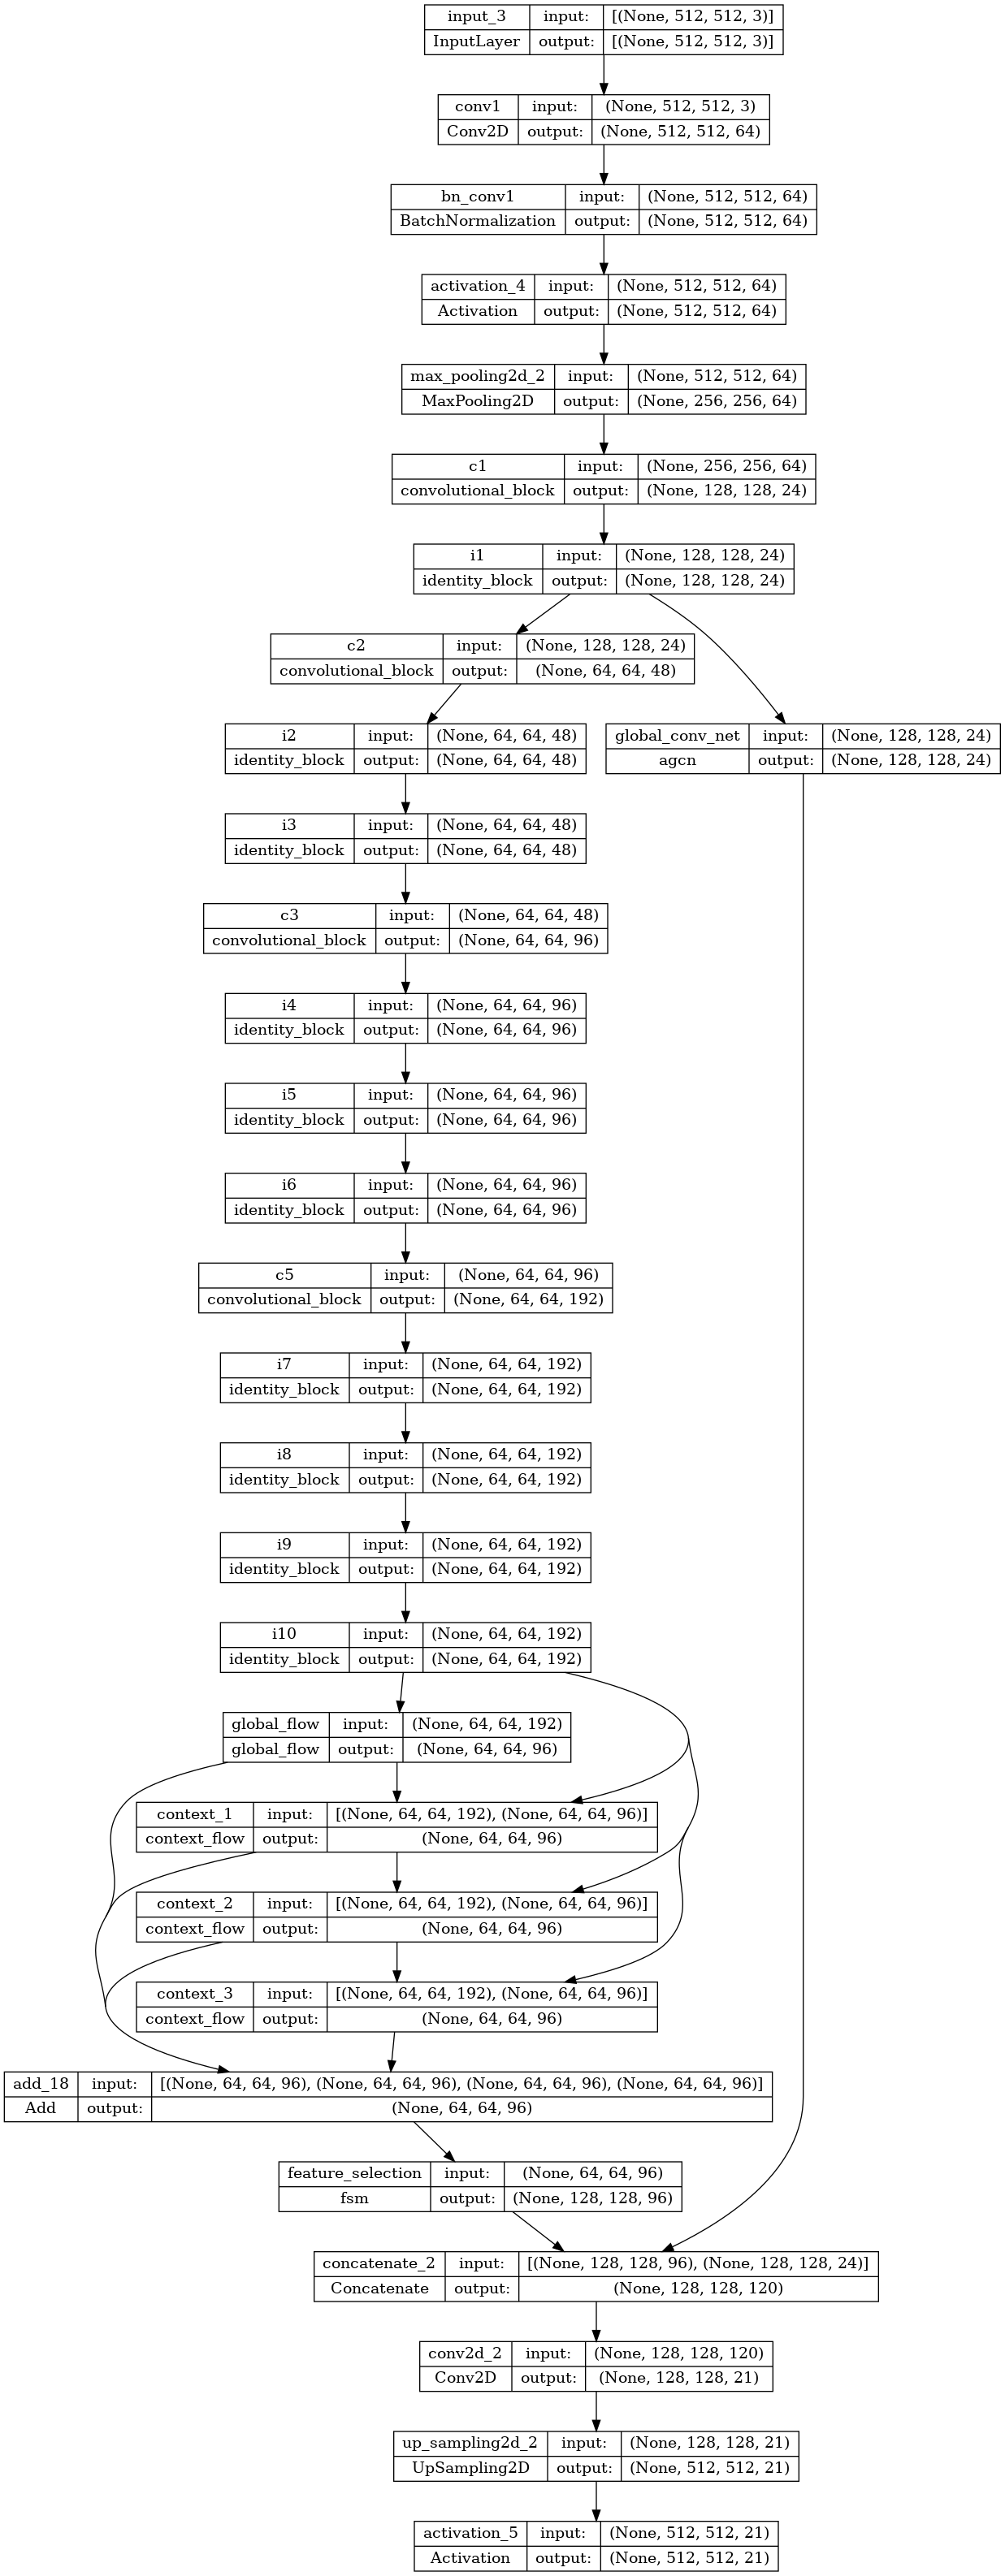

In [39]:
tf.keras.utils.plot_model(
    model_2, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [40]:
from tensorflow.keras.callbacks import Callback

class custom_callback(Callback):
    def __init__(self):
        super().__init__()
        pass
    def on_epoch_end(self,epoch, logs=None):
        self.model.save_weights('model_2/model_2_ep_'+str(epoch)+'.h5')
        pass
    

In [31]:
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet

optim = tf.keras.optimizers.Adam(0.001)

focal_loss = sm.losses.cce_dice_loss

path='model/model_2.h5'
logs='logs/model_2'
tensorboard=tf.keras.callbacks.TensorBoard(log_dir=logs,)
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=path, monitor= 'val_iou_score',
    save_best_only = True,
    mode='auto',save_weights_only=True)
lr_scheduler=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3,factor=0.5)
save_model=custom_callback()
callbacks=[checkpoint,tensorboard,lr_scheduler,save_model]

model_2.compile(optimizer=tf.keras.optimizers.experimental.Nadam(learning_rate=0.001),loss=focal_loss, metrics=[iou_score] )

model_2.fit(train_dataloader, epochs=15, validation_data=validation_dataloader, callbacks=callbacks)

Epoch 1/15


2023-02-17 04:33:42.179381: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x72fa4500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-17 04:33:42.179433: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-02-17 04:33:42.235803: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-17 04:33:42.684827: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


256/256 [==============================] - 539s 2s/step - loss: 0.8886 - iou_score: 0.1341 - val_loss: 1.0960 - val_iou_score: 0.0783 - lr: 0.0010
Epoch 2/15
256/256 [==============================] - 442s 2s/step - loss: 0.7892 - iou_score: 0.1990 - val_loss: 0.8176 - val_iou_score: 0.1797 - lr: 0.0010
Epoch 3/15
256/256 [==============================] - 486s 2s/step - loss: 0.7599 - iou_score: 0.2183 - val_loss: 0.7802 - val_iou_score: 0.2153 - lr: 0.0010
Epoch 4/15
256/256 [==============================] - 424s 2s/step - loss: 0.6395 - iou_score: 0.3336 - val_loss: 0.5414 - val_iou_score: 0.4324 - lr: 0.0010
Epoch 5/15
256/256 [==============================] - 433s 2s/step - loss: 0.5306 - iou_score: 0.4377 - val_loss: 0.6133 - val_iou_score: 0.3875 - lr: 0.0010
Epoch 6/15
256/256 [==============================] - 424s 2s/step - loss: 0.5159 - iou_score: 0.4486 - val_loss: 0.5733 - val_iou_score: 0.4146 - lr: 0.0010
Epoch 7/15
256/256 [==============================] - 429s 2s/s

In [41]:
model_2.load_weights('model_2/model_2_ep_10.h5')

In [34]:
model_2.evaluate(test_dataloader)

80/80 [==============================] - 104s 1s/step - loss: 0.4957 - iou_score: 0.4709


[0.49566537141799927, 0.470852792263031]

In [43]:
test_dataloader[0][0].shape
test_dataloader[0][1].shape
predicted_masks_2=model_2.predict(test_dataloader[0][0])

1/1 [==============================] - 3s 3s/step


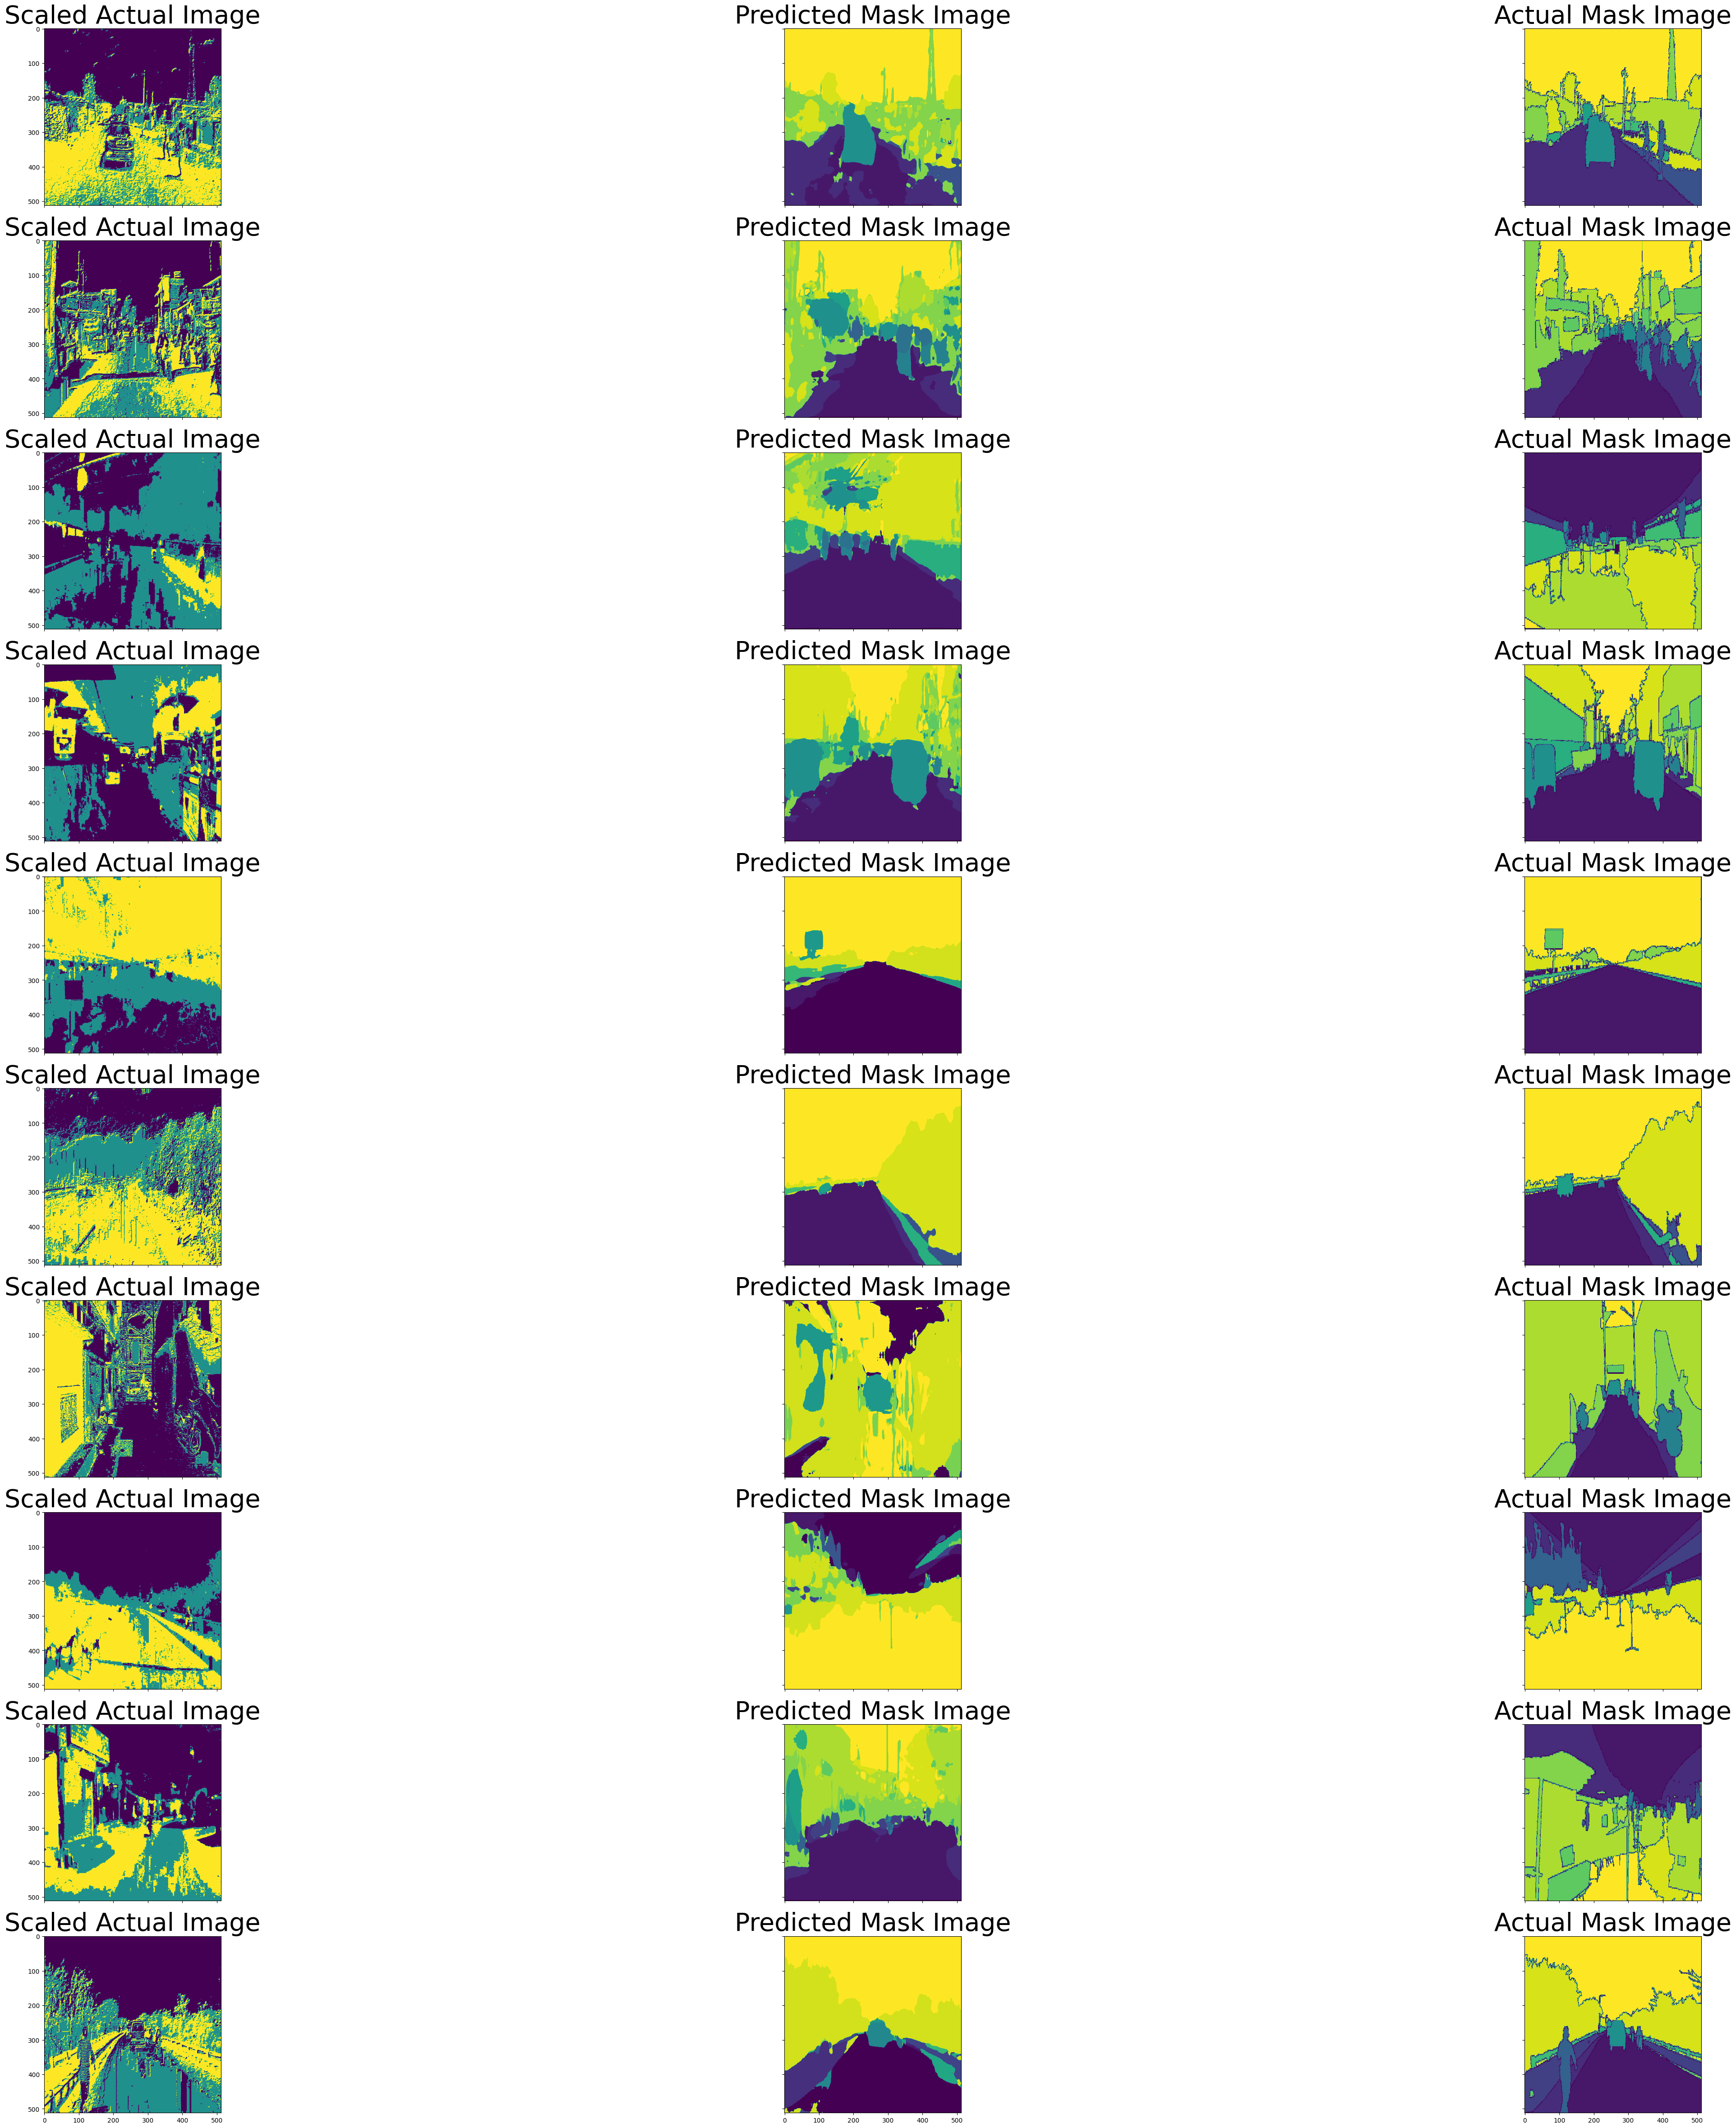

In [44]:
fig,ax=plt.subplots(10,3,figsize=(60, 60), squeeze=False,sharex=True, sharey=True)
for i in range(10):
    ax[i,0].imshow(np.argmax(test_dataloader[0][0][i], axis=-1))
    ax[i,0].set_title('Scaled Actual Image',fontsize = 40)
    ax[i,1].imshow(np.argmax(predicted_masks_2[i], axis=-1))
    ax[i,1].set_title('Predicted Mask Image',fontsize = 40)
    ax[i,2].imshow(np.argmax(test_dataloader[0][1][i], axis=-1))
    ax[i,2].set_title('Actual Mask Image',fontsize = 40)

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

### Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations